In [1]:
!pip install datasets pillow tqdm

In [2]:
import os
import random
import zipfile
import json

from tqdm import tqdm
from datasets import load_dataset
from PIL import Image

# ---------- CONFIG ----------
NUM_IMAGES = 5000        # change to 1000, 2000, 3000 if needed
OUT_DIR = "data"
IMG_DIR = os.path.join(OUT_DIR, "images")
JSON_PATH = os.path.join(OUT_DIR, "dataset.json")
ZIP_PATH = "flickr8k_subset.zip"
HF_DATASET = "tsystems/flickr8k"
# -----------------------------

In [3]:
print(f"Loading Flickr8k dataset from HuggingFace: {HF_DATASET}")
ds = load_dataset(HF_DATASET, split="train")

total = len(ds)
print(f"Total images available: {total}")

n = min(NUM_IMAGES, total)
print(f"Using {n} images")

Loading Flickr8k dataset from HuggingFace: tsystems/flickr8k


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/492 [00:00<?, ?B/s]

data/train-00000-of-00003.parquet:   0%|          | 0.00/373M [00:00<?, ?B/s]

data/train-00001-of-00003.parquet:   0%|          | 0.00/364M [00:00<?, ?B/s]

data/train-00002-of-00003.parquet:   0%|          | 0.00/379M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8091 [00:00<?, ? examples/s]

Total images available: 8091
Using 5000 images


In [4]:
os.makedirs(IMG_DIR, exist_ok=True)
print(f"Created folder: {IMG_DIR}")

Created folder: data/images


In [5]:
indices = random.sample(range(total), n)
rows = []

print(f"Saving {n} images and building metadata…")

for i in tqdm(indices):
    item = ds[i]
    img: Image.Image = item["image"]
    captions = item["captions"]

    # Combine all captions
    text = " ".join(captions) if isinstance(captions, list) else ""

    filename = f"flickr8k_{i}.jpg"
    img_rel = f"images/{filename}"
    img_abs = os.path.join(IMG_DIR, filename)

    img.convert("RGB").save(img_abs, "JPEG")

    rows.append({
        "image_path": img_rel,
        "text": text
    })

print("Done!")

Saving 5000 images and building metadata…


100%|██████████| 5000/5000 [00:31<00:00, 158.76it/s]

Done!


In [6]:
print(f"Writing JSON file to: {JSON_PATH}")

with open(JSON_PATH, "w", encoding="utf-8") as f:
    json.dump(rows, f, indent=2)

print("JSON saved successfully!")

Writing JSON file to: data/dataset.json
JSON saved successfully!


In [7]:
print(f"Creating ZIP archive: {ZIP_PATH}")

with zipfile.ZipFile(ZIP_PATH, "w", zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(JSON_PATH, arcname=os.path.join("data", "dataset.json"))
    for row in tqdm(rows, desc="Adding images"):
        img_abs = os.path.join(OUT_DIR, row["image_path"])
        zipf.write(img_abs, arcname=os.path.join("data", row["image_path"]))

print("ZIP file created successfully!")

Creating ZIP archive: flickr8k_subset.zip


Adding images: 100%|██████████| 5000/5000 [00:08<00:00, 599.63it/s]

ZIP file created successfully!


In [8]:
print("Completed!")
print(f"- Images saved in: {IMG_DIR}")
print(f"- JSON file:       {JSON_PATH}")
print(f"- ZIP file:        {ZIP_PATH}")

Completed!
- Images saved in: data/images
- JSON file:       data/dataset.json
- ZIP file:        flickr8k_subset.zip


In [9]:
!pip install datasets pillow tqdm transformers faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 27.4 MB/s eta 0:00:00


In [ ]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
image_embeddings = []
text_embeddings = []

for item in tqdm(rows, desc="Computing embeddings"):
    # Text embedding
    inputs_text = processor(text=item["text"], return_tensors="pt", padding=True, truncation=True, max_length=77).to(DEVICE)
    with torch.no_grad():
        text_emb = model.get_text_features(**inputs_text)
        text_emb = text_emb / text_emb.norm(p=2, dim=-1, keepdim=True)
        text_embeddings.append(text_emb.cpu().numpy())

    # Image embedding
    img = Image.open(os.path.join(OUT_DIR, item["image_path"])).convert("RGB")
    inputs_img = processor(images=img, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        img_emb = model.get_image_features(**inputs_img)
        img_emb = img_emb / img_emb.norm(p=2, dim=-1, keepdim=True)
        image_embeddings.append(img_emb.cpu().numpy())

image_embeddings = np.vstack(image_embeddings)
text_embeddings = np.vstack(text_embeddings)

# Save embeddings
np.save(os.path.join(OUT_DIR, "image_embeddings.npy"), image_embeddings)
np.save(os.path.join(OUT_DIR, "text_embeddings.npy"), text_embeddings)
print("Embeddings saved!")

Computing embeddings: 100%|██████████| 5000/5000 [33:51<00:00,  2.46it/s]

Embeddings saved!


In [ ]:
dim = image_embeddings.shape[1]

index_img = faiss.IndexFlatIP(dim)  # For text->image search
index_img.add(image_embeddings)

index_text = faiss.IndexFlatIP(dim)  # For image->text search
index_text.add(text_embeddings)

print("FAISS indexes built!")

FAISS indexes built!


In [ ]:
def retrieve_images(query_text, k=5):
    inputs = processor(text=query_text, return_tensors="pt", padding=True).to(DEVICE)
    with torch.no_grad():
        q_emb = model.get_text_features(**inputs)
        q_emb = q_emb / q_emb.norm(p=2, dim=-1, keepdim=True)
        q_emb = q_emb.cpu().numpy().astype("float32")

    distances, indices = index_img.search(q_emb, k)
    return [rows[i]["image_path"] for i in indices[0]]

def retrieve_texts(query_img, k=5):
    inputs = processor(images=query_img, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        q_emb = model.get_image_features(**inputs)
        q_emb = q_emb / q_emb.norm(p=2, dim=-1, keepdim=True)
        q_emb = q_emb.cpu().numpy().astype("float32")

    distances, indices = index_text.search(q_emb, k)
    return [rows[i]["text"] for i in indices[0]]

In [ ]:
from PIL import Image
from IPython.display import display

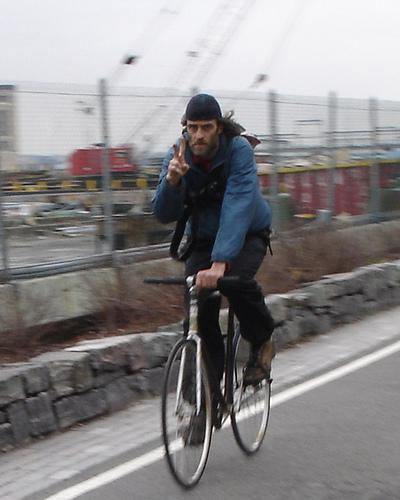

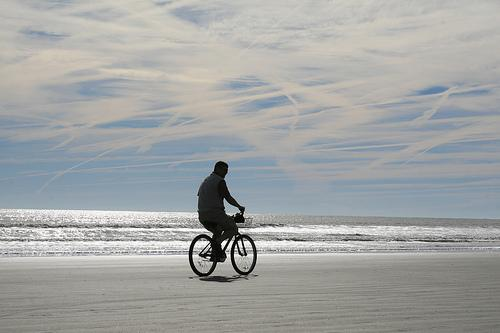

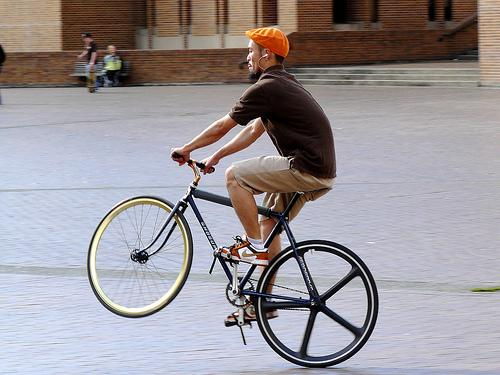

In [ ]:
# Test Text -> Image
results = retrieve_images("A man is riding a bike", k=3)
for r in results:
    img = Image.open(os.path.join(OUT_DIR, r))
    display(img)

In [ ]:
# Test Image -> Text
img_path = os.path.join(OUT_DIR, results[0])
img = Image.open('/content/data/images/flickr8k_1002.jpg')
texts = retrieve_texts(img, k=3)
for t in texts:
    print(t)

Two dogs drink water in a lake . Two white dogs are drinking water out of a lake . Two white dogs drink from the lake . two white dogs drinking out of a stream Two white dogs walk around in shallow water .
A dog jumps out of a creek . A white dog in a creek . A white dog is jumping in natural water . A yellow dog shaking off from a jump into a stream . The furry beige dog is playing in the murky river water .
A white dog fetches a stick as he swims in a lake A white dog holds a stick while swimming . A white dog retrieves the stick from the lake for her owner . A white dog swims with a stick . White dog retrieving stick from water
